In [49]:
import sys
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

In [50]:
# Do change runtime to GPU!

## § 17.2.	Performing PCA with an Undercomplete Linear Autoencoder

In [51]:
import tensorflow as tf

In [52]:
tf.random.set_seed(42) # added ex-post: ensures reproducibility

In [53]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse",
                    optimizer=optimizer)

In [54]:
# added ex-post: build the same 3D dataset as in § 8

import numpy as np
from scipy.spatial.transform import Rotation

In [55]:
# ditto

m = 60
X = np.zeros((m, 3)) # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5 # oval
X += 0.28 * np.random.randn(m, 3) # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2] # shift a little bit

In [56]:
# X_train = [...] # generate a 3D dataset, like in § 8
history = autoencoder.fit(X_train, X_train,
                          epochs=500,
                          verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 4ms/step


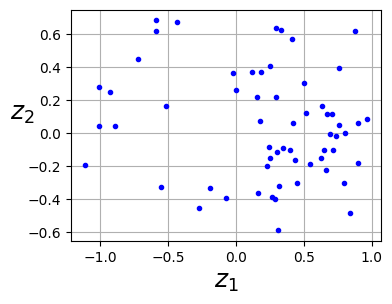

In [57]:
# added ex-post: plot it
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## § 17.3.	Stacked Autoencoders

In [58]:
# added ex-post: load, scale and split the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### § 17.3.1.	Implementing a Stacked Autoencoder Using Keras

In [59]:
tf.random.set_seed(42) # ditto above

In [60]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse",
                   optimizer="nadam")
history = stacked_ae.fit(X_train, X_train,
                         epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0227 - val_loss: 0.0172
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 8/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0136 - val_loss: 0.0141
Epoch 9/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 10/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.013

### § 17.3.2.	Visualizing the Reconstructions

In [61]:
import numpy as np

In [62]:
def plot_reconstructions(model, images=X_valid, n_images=5):
  reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plt.imshow(images[image_index], cmap="binary")
    plt.axis("off")
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plt.imshow(reconstructions[image_index], cmap="binary")
    plt.axis("off")

1/1 [==============================] - 0s 70ms/step


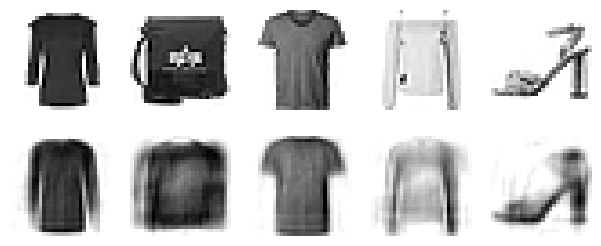

In [63]:
plot_reconstructions(stacked_ae)
plt.show()

### § 17.3.3.	Visualizing the Fashion MNIST Dataset

In [64]:
from sklearn.manifold import TSNE

In [65]:
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


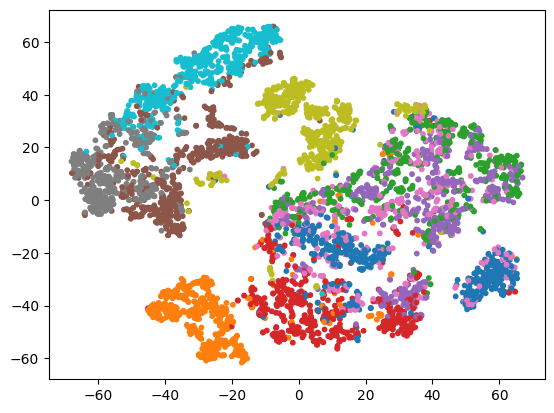

In [66]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show() # added ex-post

In [67]:
# added ex-post: prettify, adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl

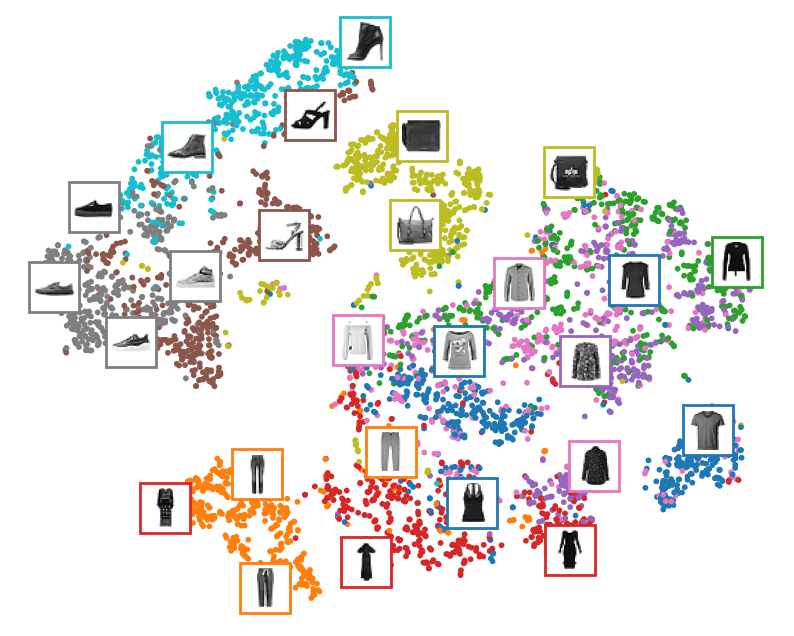

In [68]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min()) # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
  dist = ((position - image_positions) ** 2).sum(axis=1)
  if dist.min() > 0.02: # if far enough from other images
    image_positions = np.r_[image_positions, [position]]
    imagebox = mpl.offsetbox.AnnotationBbox(
        mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
        position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
    plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

### § 17.3.5.	Tying Weights

In [69]:
class DenseTranspose(tf.keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    super().__init__(**kwargs)
    self.dense = dense
    self.activation = tf.keras.activations.get(activation)

  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias",
                                  shape=self.dense.input_shape[-1],
                                  initializer="zeros")
    super().build(batch_input_shape)

  def call(self, inputs):
    Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(Z + self.biases)

In [70]:
tf.random.set_seed(42)

In [71]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

In [72]:
# added ex-post: compile & fit the model
tied_ae.compile(loss="mse",
                optimizer="nadam")
history = tied_ae.fit(X_train, X_train,
                      epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0223 - val_loss: 0.0168
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0137 - val_loss: 0.0138
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 9/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.013

1/1 [==============================] - 0s 64ms/step


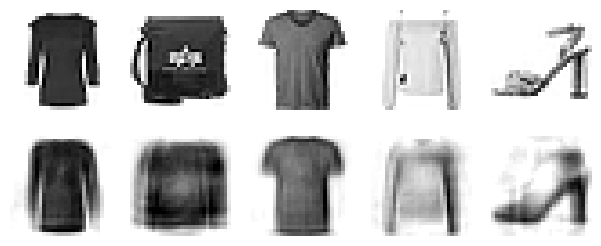

In [73]:
# added ex-post: plot reconstructions
plot_reconstructions(tied_ae)
plt.show()

In [74]:
# added es-post: [extra material] training 1 autoencoder at a time
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10, output_activation=None):
  n_inputs = X_train.shape[-1]
  encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
  decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
  autoencoder = tf.keras.Sequential([encoder, decoder])
  autoencoder.compile(loss="mse", optimizer="nadam")
  autoencoder.fit(X_train, X_train,
                  epochs=n_epochs,
                  validation_data=(X_valid, X_valid))
  return encoder, decoder, encoder(X_train), encoder(X_valid)

In [75]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.0185 - val_loss: 0.0118
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 8/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 10/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.009

In [76]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 95ms/step


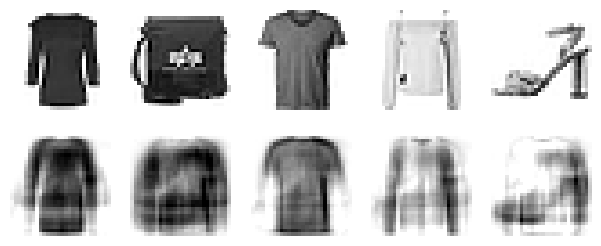

In [77]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

In [78]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train,
                                epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 10s 4ms/step - loss: 0.0178 - val_loss: 0.0167
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0141 - val_loss: 0.0142


1/1 [==============================] - 0s 61ms/step


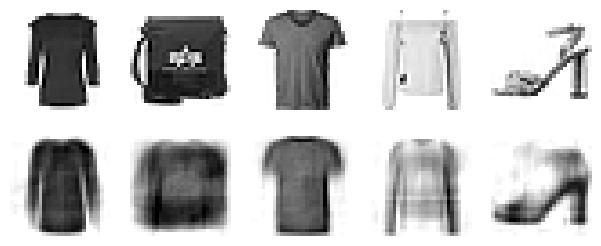

In [79]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## § 17.4.	Convolutional Autoencoders

In [80]:
tf.random.set_seed(42)

In [81]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 14 x 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 7 x 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 3 x 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D() # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

In [82]:
# added ex-post: compile & fit the model
conv_ae.compile(loss="mse",
                optimizer="nadam")
history = conv_ae.fit(X_train, X_train,
                      epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 19s 8ms/step - loss: 0.0288 - val_loss: 0.0205
Epoch 2/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0184 - val_loss: 0.0173
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 4/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 8/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 9/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0126 - val_loss: 0.0130
Epoch 10/10
1719/1719 [==============================] - 13s 7ms/step - l

1/1 [==============================] - 0s 398ms/step


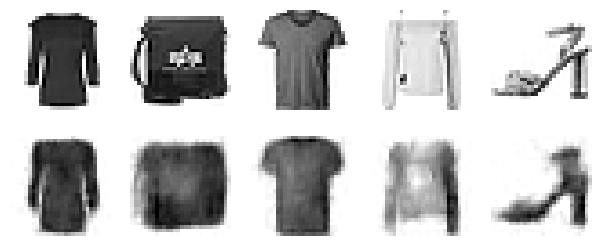

In [83]:
# added ex-post: plot the reconstructions
plot_reconstructions(conv_ae)
plt.show()

In [84]:
# added ex-post: [extra material] recurrent autoencoders
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])

In [85]:
recurrent_ae.compile(loss="mse",
                     optimizer="nadam")
history = recurrent_ae.fit(X_train, X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 28s 11ms/step - loss: 0.0260 - val_loss: 0.0195
Epoch 2/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0174 - val_loss: 0.0160
Epoch 3/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 5/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0131 - val_loss: 0.0128
Epoch 6/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 7/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0118 - val_loss: 0.0120
Epoch 8/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0114 - val_loss: 0.0117
Epoch 9/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 10/10
1719/1719 [==============================] - 19s 11m

1/1 [==============================] - 1s 1s/step


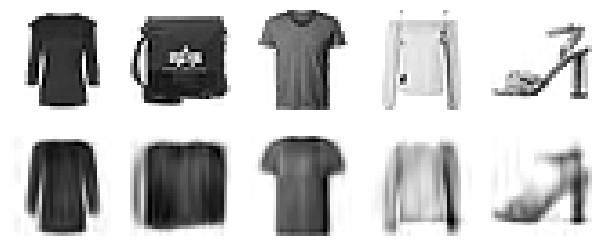

In [86]:
plot_reconstructions(recurrent_ae)
plt.show()

## § 17.5.	Denoising Autoencoders

In [87]:
tf.random.set_seed(42)

In [88]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

In [89]:
# added ex-post: compile & fit the model
dropout_ae.compile(loss="mse",
                   optimizer="nadam")
history = dropout_ae.fit(X_train, X_train,
                         epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 4ms/step - loss: 0.0293 - val_loss: 0.0216
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0222 - val_loss: 0.0198
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0210 - val_loss: 0.0190
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0204 - val_loss: 0.0187
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0200 - val_loss: 0.0183
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0197 - val_loss: 0.0181
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0192 - val_loss: 0.0175
Epoch 9/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 10/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.01

1/1 [==============================] - 0s 67ms/step


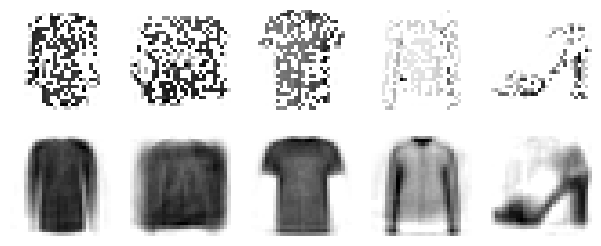

In [90]:
# added ex-post: plot
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

## § 17.6.	Sparse Autoencoders

In [91]:
tf.random.set_seed(42)

In [92]:
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [93]:
# added ex-post: compile & fit the model
sparse_l1_ae.compile(loss="mse",
                     optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.0279 - val_loss: 0.0194
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0172 - val_loss: 0.0158
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0149 - val_loss: 0.0145
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 8/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 9/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.01

1/1 [==============================] - 0s 74ms/step


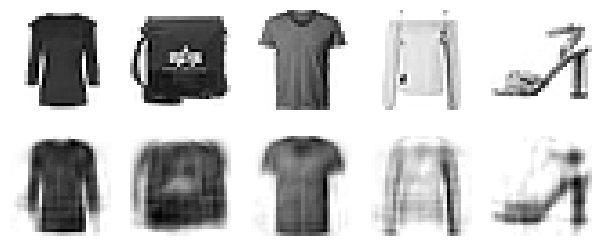

In [94]:
# added ex-post: plot the reconstructions
plot_reconstructions(sparse_l1_ae)
plt.show()

In [95]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence # added ex-post

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, weight, target):
    self.weight = weight
    self.target = target

  def __call__(self, inputs):
    mean_activities = tf.reduce_mean(inputs, axis=0)
    return self.weight * (
        kl_divergence(self.target, mean_activities) +
        kl_divergence(1. - self.target, 1. - mean_activities)
    )

In [96]:
tf.random.set_seed(42)

In [97]:
kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

In [98]:
# added ex-post: compile & fit the model
sparse_kl_ae.compile(loss="mse",
                     optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train,
                           epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 5ms/step - loss: 0.0258 - val_loss: 0.0173
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0127 - val_loss: 0.0138
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 8/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 9/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 10/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.00

1/1 [==============================] - 0s 91ms/step


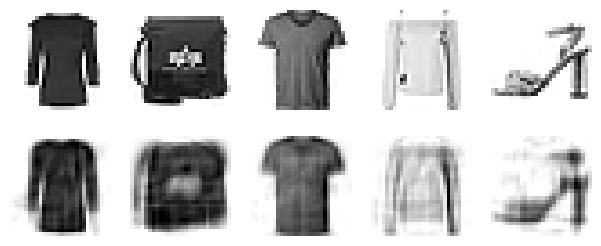

In [99]:
# added ex-post: plot the reconstructions
plot_reconstructions(sparse_kl_ae)
plt.show()

## § 17.7.	Variational Autoencoders

In [100]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [101]:
tf.random.set_seed(42)

In [102]:
codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

In [103]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [104]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [105]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1
)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [106]:
variational_ae.compile(loss="mse",
                       optimizer="nadam")
history = variational_ae.fit(X_train, X_train,
                             epochs=25,
                             batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 8s 7ms/step - loss: 0.0512 - val_loss: 0.0386
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0367 - val_loss: 0.0356
Epoch 3/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0347 - val_loss: 0.0346
Epoch 4/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0338 - val_loss: 0.0336
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0332 - val_loss: 0.0332
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0328 - val_loss: 0.0330
Epoch 7/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0324 - val_loss: 0.0326
Epoch 8/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0322 - val_loss: 0.0328
Epoch 9/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0320 - val_loss: 0.0326
Epoch 10/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0318 - val_loss: 0.0324

1/1 [==============================] - 0s 130ms/step


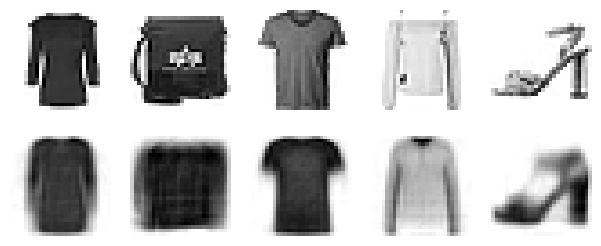

In [107]:
# added ex-post: plot
plot_reconstructions(variational_ae)
plt.show()

## § 17.8.	Generating Fashion MNIST Images

In [108]:
tf.random.set_seed(42)

In [109]:
codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [110]:
# added ex-post: plot function

def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = images.squeeze(axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

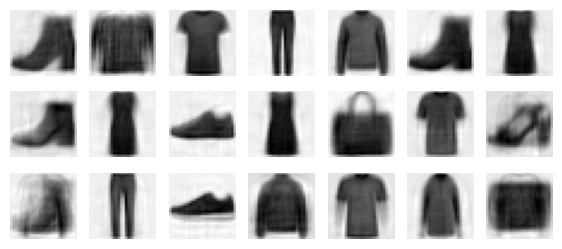

In [111]:
plot_multiple_images(images, 7)
plt.show()

In [112]:
tf.random.set_seed(42)

In [113]:
codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7) # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

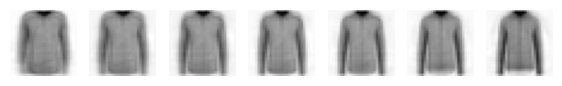

In [114]:
# added ex-post: plot
plot_multiple_images(images)
plt.show()

## § 17.9.	Generative Adversarial Networks

In [115]:
tf.random.set_seed(42)

In [116]:
codings_size = 30

In [117]:
Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="relu")
])
gan = tf.keras.Sequential([generator, discriminator])

In [118]:
discriminator.compile(loss="binary_crossentropy",
                      optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",
            optimizer="rmsprop")

In [119]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


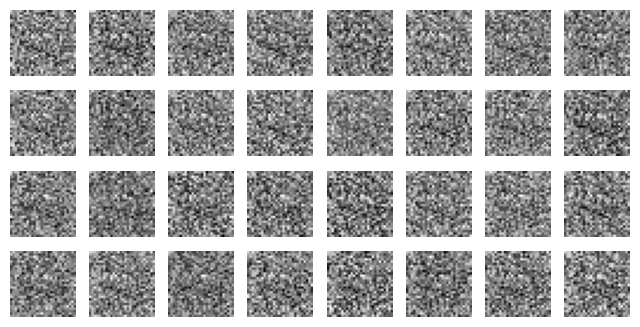

Epoch 2/50


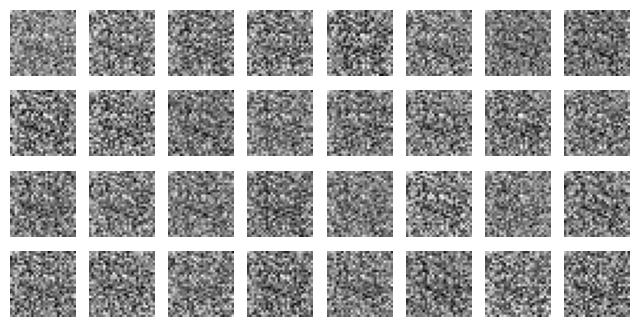

Epoch 3/50


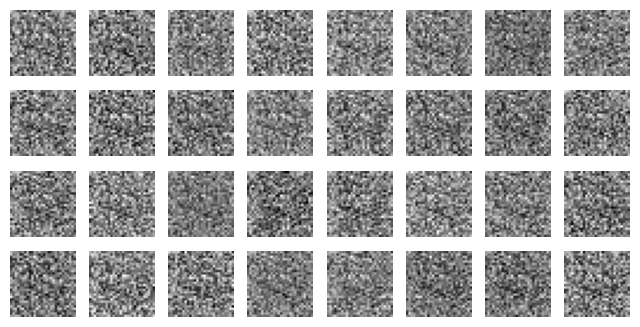

Epoch 4/50


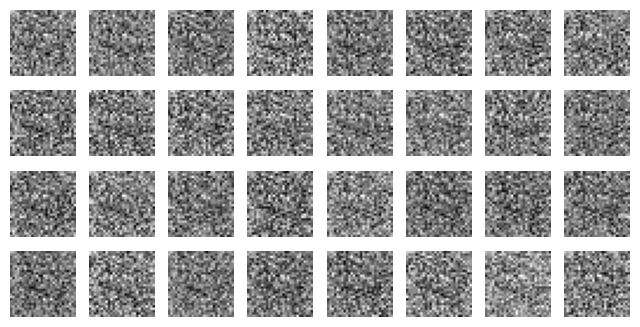

Epoch 5/50


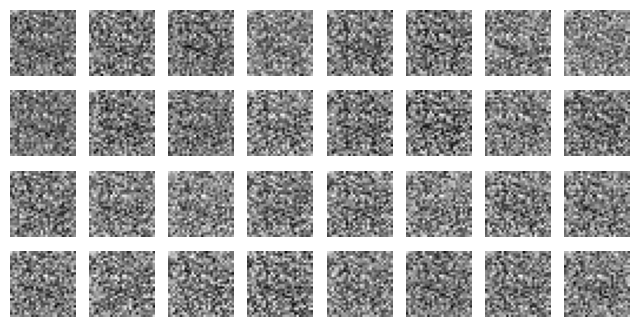

Epoch 6/50


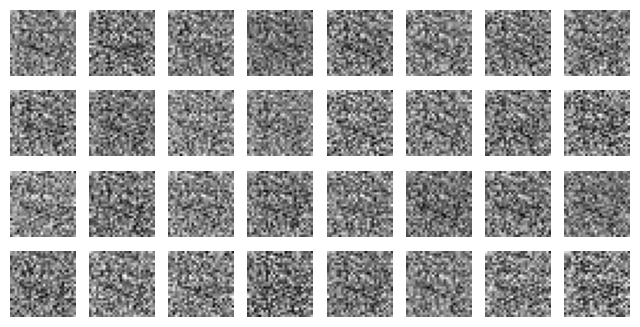

Epoch 7/50


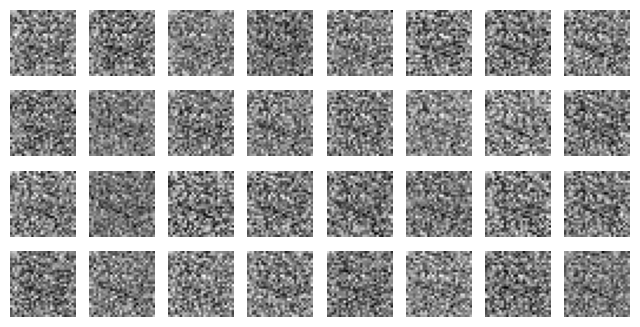

Epoch 8/50


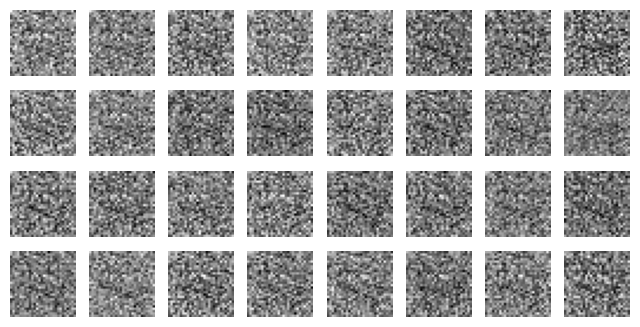

Epoch 9/50


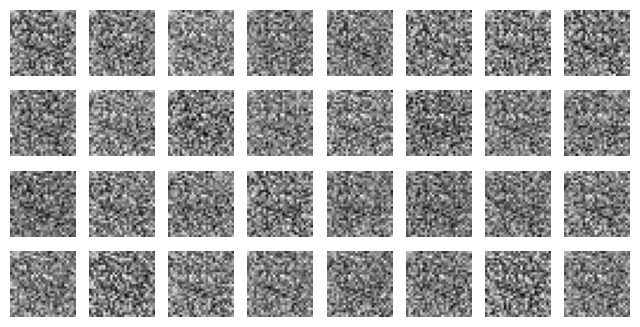

Epoch 10/50


KeyboardInterrupt: ignored

In [120]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}") # added ex-post
    for X_batch in dataset:
      # phase 1 - training the discriminator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.train_on_batch(X_fake_and_real, y1)
      # phase 2 - training the generator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      gan.train_on_batch(noise, y2)
    # extra code — plot images during training
    plot_multiple_images(generated_images.numpy(), 8)
    plt.show()

train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

In [ ]:
tf.random.set_seed(42)

In [ ]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

In [ ]:
# added ex-post: plot
plot_multiple_images(generated_images, 8)
plt.show()

### § 17.9.2.	Deep Convolutional GANs

In [121]:
tf.random.set_seed(42)

In [122]:
codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                    activation="tanh")
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [123]:
# added ex-post: compile the discrimator and the gan, see above
discriminator.compile(loss="binary_crossentropy",
                      optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",
            optimizer="rmsprop")

In [124]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape & rescale

Epoch 1/20


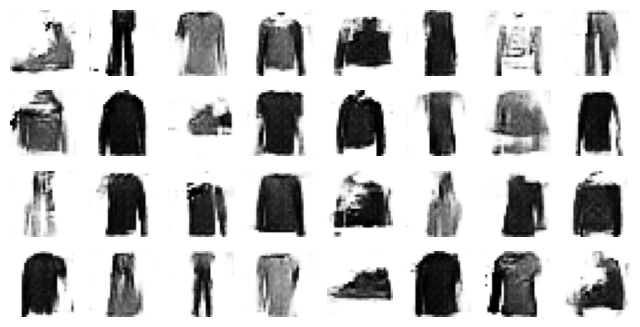

Epoch 2/20


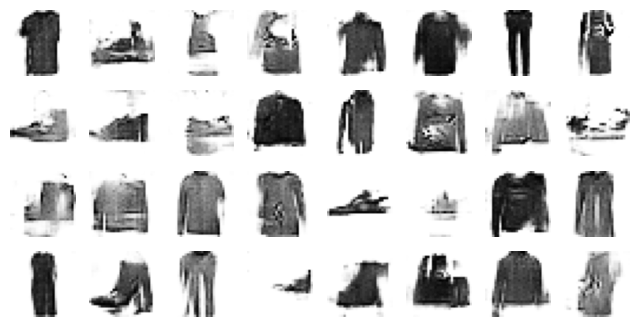

Epoch 3/20


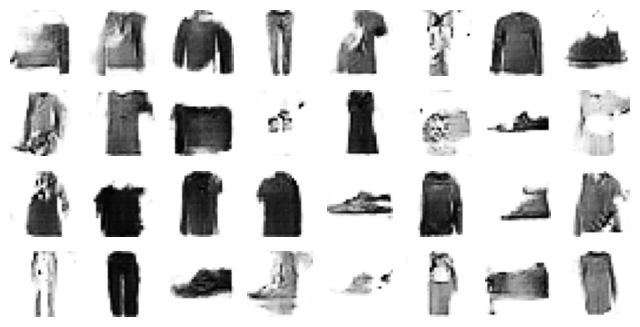

Epoch 4/20


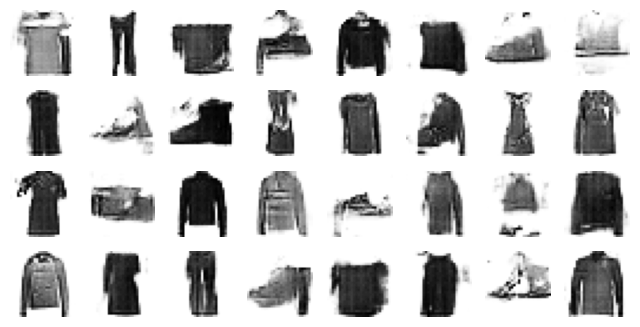

Epoch 5/20


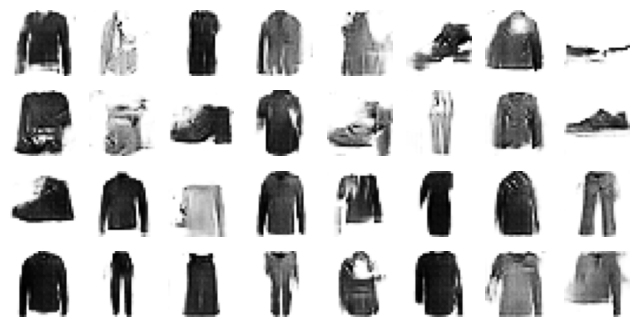

Epoch 6/20


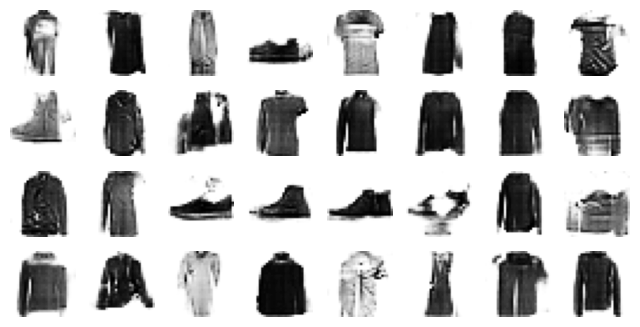

Epoch 7/20


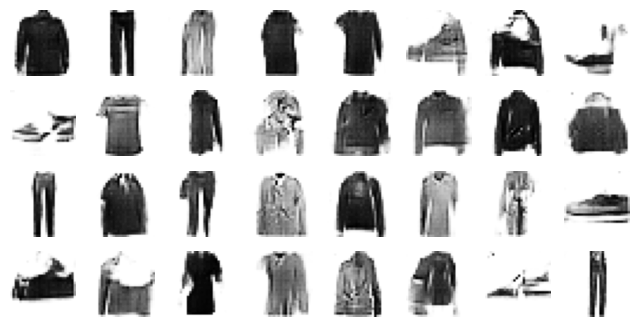

Epoch 8/20


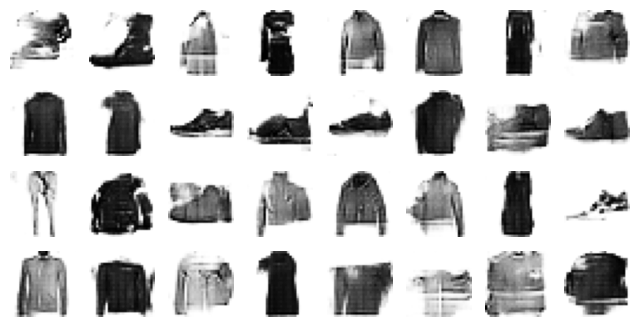

Epoch 9/20


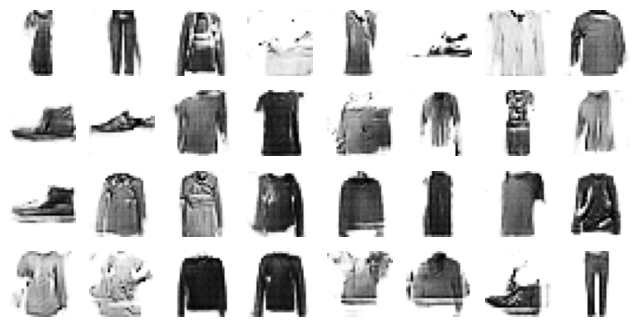

Epoch 10/20


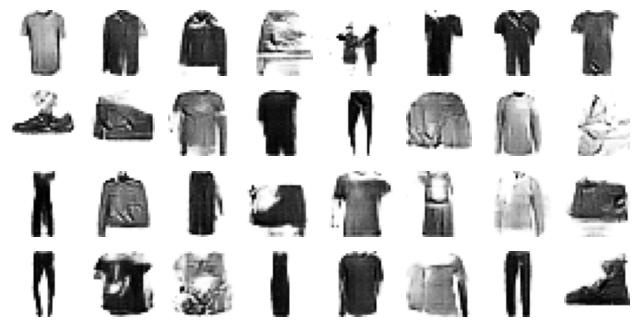

Epoch 11/20


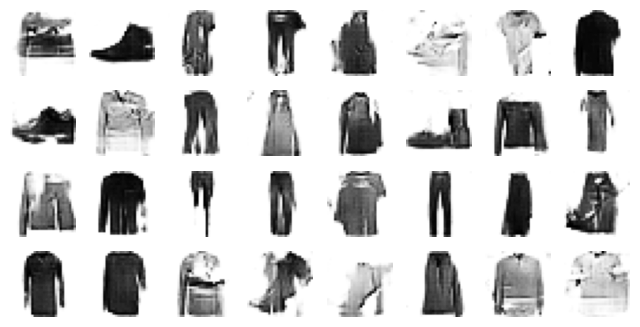

Epoch 12/20


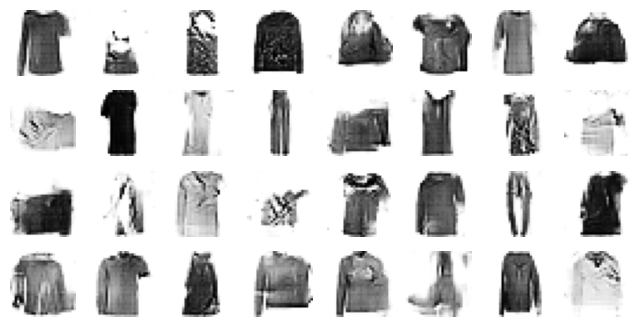

Epoch 13/20


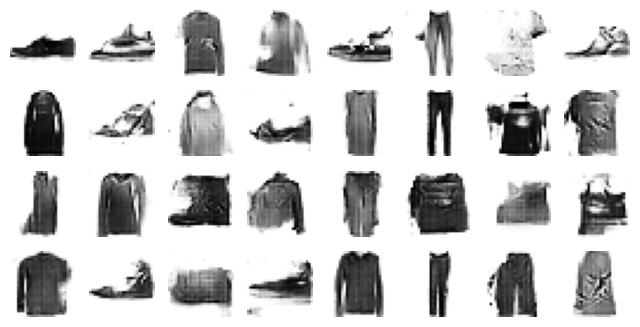

Epoch 14/20


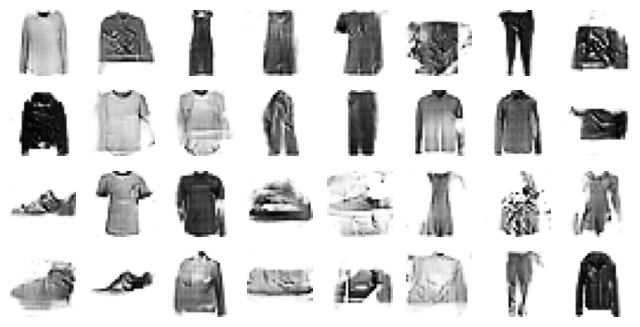

Epoch 15/20


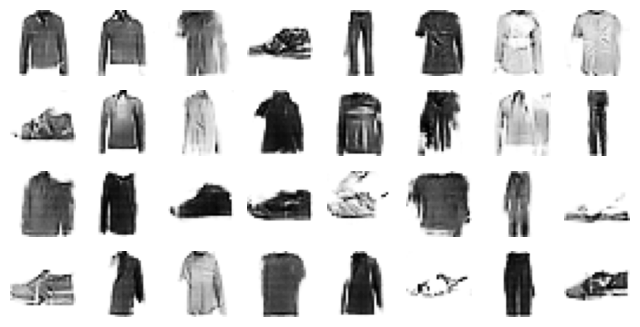

Epoch 16/20


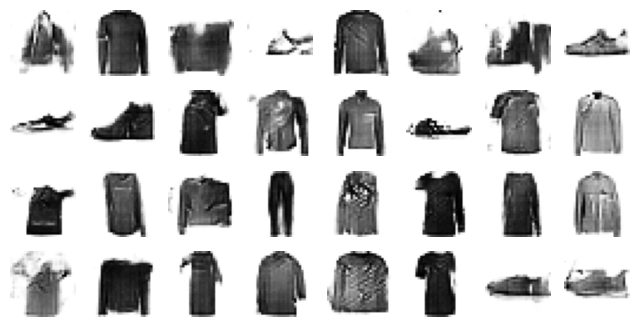

Epoch 17/20


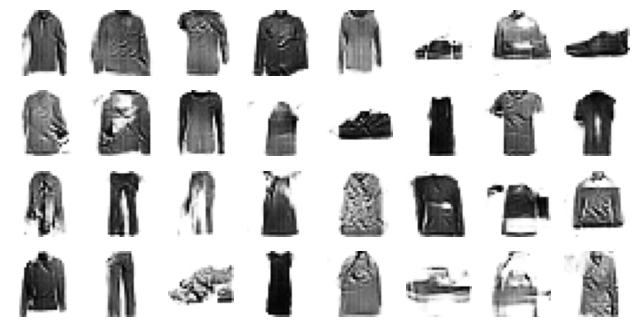

Epoch 18/20


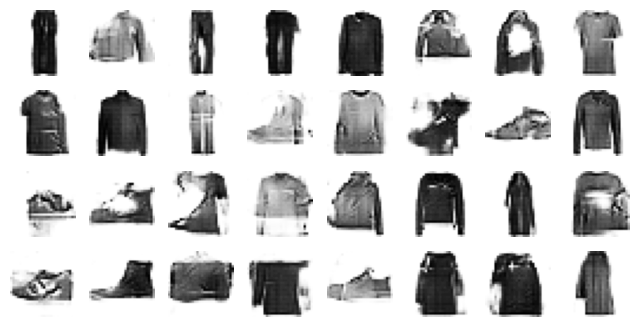

Epoch 19/20


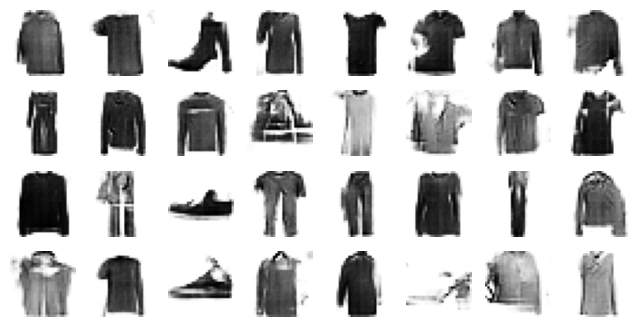

Epoch 20/20


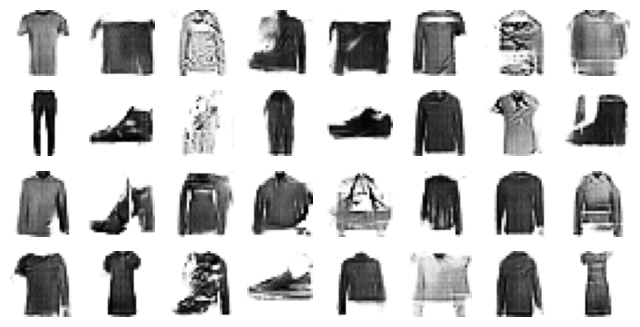

In [126]:
# added ex-post: generate the dataset and train the GAN, see above
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
# train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=20)

1/1 [==============================] - 0s 118ms/step


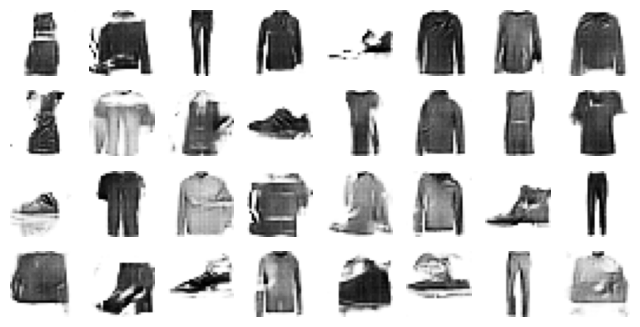

In [127]:
# added ex-post: plot
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)

## § 17.10.	Diffusion Models

In [128]:
def variance_schedule(T, s=0.008, max_beta=0.999):
  t = np.arange(T + 1)
  f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
  alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
  alpha = np.append(1, alpha).astype(np.float32) # add a0 = 1
  beta = 1 - alpha
  alpha_cumprod = np.cumprod(alpha)
  return alpha, alpha_cumprod, beta # at, at_, ßt for t = 0 to T

np.random.seed(42) # added ex-post: ensures reproducibility

T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

In [129]:
def prepare_batch(X):
  X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1 # scale from -1 to +1
  X_shape = tf.shape(X)
  t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
  alpha_cm = tf.gather(alpha_cumprod, t)
  alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) -1))
  noise = tf.random.normal(X_shape)
  return {
      "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
      "time": t
  }, noise

In [130]:
def prepare_dataset(X, batch_size=32, shuffle=False):
  ds = tf.data.Dataset.from_tensor_slices(X)
  if shuffle:
    ds = ds.shuffle(buffer_size=10_000)
  return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(42)
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

In [131]:
def build_diffusion_model():
  X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
  time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
  [...] # build the model based on the noisy images and the time steps
  outputs = [...] # predict the noise (same shape as the input images)
  return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

Original images


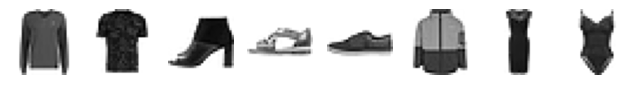

Time steps: [2644 3772 3918 1208 3304 2526 2095 2652]
Noisy images


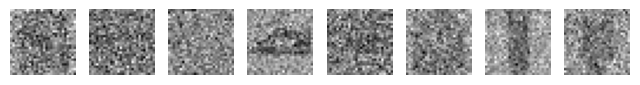

Noise to predict


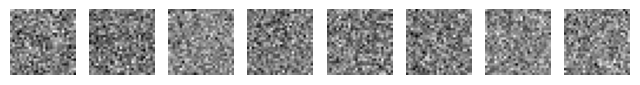

In [132]:
# added ex-post: just a quick sanity check

def subtract_noise(X_noisy, time, noise):
  X_shape = tf.shape(X_noisy)
  alpha_cm = tf.gather(alpha_cumprod, time)
  alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
  return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0] # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

In [133]:
# added ex-post: implements a custom time encoding layer

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
  def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
    super().__init__(dtype=dtype, **kwargs)
    assert embed_size % 2 == 0, "embed_size must be even"
    p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
    t_emb = np.empty((T + 1, embed_size))
    t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
    t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
    self.time_encodings = tf.constant(t_emb.astype(self.dtype))

  def call(self, inputs):
    return tf.gather(self.time_encodings, inputs)

In [134]:
def build_diffusion_model():
  X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
  time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
  time_enc = TimeEncoding(T, embed_size)(time_input)

  dim = 16
  Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
  Z = tf.keras.layers.Conv2D(dim, 3)(Z)
  Z = tf.keras.layers.BatchNormalization()(Z)
  Z = tf.keras.layers.Activation("relu")(Z)

  time = tf.keras.layers.Dense(dim)(time_enc) # adapt time encoding
  Z = time[:, tf.newaxis, tf.newaxis, :] + Z # add time data to every pixel

  skip = Z
  cross_skips = [] # skip connections across the down & up parts of the UNet

  for dim in (32, 64, 128):
    Z = tf.keras.layers.Activation("relu")(Z)
    Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)

    Z = tf.keras.layers.Activation("relu")(Z)
    Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)

    cross_skips.append(Z)
    Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
    skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2, padding="same")(skip)
    Z = tf.keras.layers.add([Z, skip_link])

    time = tf.keras.layers.Dense(dim)(time_enc)
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z
    skip = Z

  for dim in (64, 32, 16):
    Z = tf.keras.layers.Activation("relu")(Z)
    Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)

    Z = tf.keras.layers.Activation("relu")(Z)
    Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)

    Z = tf.keras.layers.UpSampling2D(2)(Z)

    skip_link = tf.keras.layers.UpSampling2D(2)(skip)
    skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
    Z = tf.keras.layers.add([Z, skip_link])

    time = tf.keras.layers.Dense(dim)(time_enc)
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z
    Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
    skip = Z

  outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
  return tf.keras.Model(inputs=[X_noisy, time_input],
                        outputs=[outputs])

In [135]:
tf.random.set_seed(42)

In [136]:
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="nadam")

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model", save_best_only=True) # added ex-post

history = model.fit(train_set,
                    # epochs=100,
                    epochs=10,
                    validation_data=valid_set,
                    callbacks=[checkpoint_cb]) # added ex-post

Epoch 1/10
1719/1719 [==============================] - 89s 36ms/step - loss: 0.1031 - val_loss: 0.0659
Epoch 2/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.0592 - val_loss: 0.0555
Epoch 3/10
1719/1719 [==============================] - 61s 35ms/step - loss: 0.0522 - val_loss: 0.0495
Epoch 4/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.0485 - val_loss: 0.0471
Epoch 5/10
1719/1719 [==============================] - 61s 35ms/step - loss: 0.0467 - val_loss: 0.0455
Epoch 6/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.0453 - val_loss: 0.0446
Epoch 7/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.0444 - val_loss: 0.0443
Epoch 8/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.0436 - val_loss: 0.0437
Epoch 9/10
1719/1719 [==============================] - 61s 35ms/step - loss: 0.0430 - val_loss: 0.0426
Epoch 10/10
1719/1719 [==============================] - 59s 34m

In [137]:
def generate(model, batch_size=32):
  X = tf.random.normal([batch_size, 28, 28, 1])
  for t in range(T, 0, -1):
    print(f"\rt = {t}", end=" ") # added ex-post, to show progress
    noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
    X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
    X = (
        1 / alpha[t] ** 0.5
        * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
        + (1 - alpha[t]) ** 0.5 * noise
    )
  return X

tf.random.set_seed(42)
X_gen = generate(model) # generated images

t = 1 

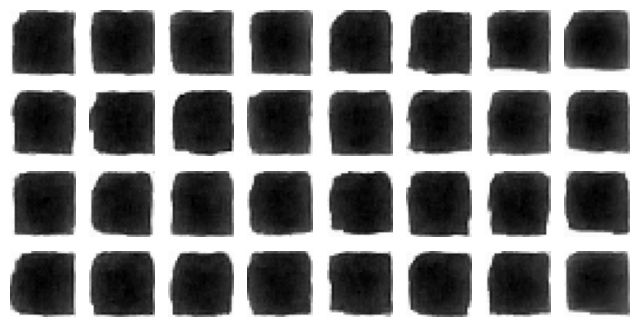

In [138]:
# added ex-post: plot
plot_multiple_images(X_gen.numpy(), 8)
plt.show()

In [139]:
import tensorflow as tf

In [140]:
# added ex-post: [extra material] hashing using a binary autoencoder
tf.random.set_seed(42)

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="mse",
                   optimizer="nadam")
history = hashing_ae.fit(X_train, X_train,
                         epochs=10,
                         # epochs=2,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.0549 - val_loss: 0.0533
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0429 - val_loss: 0.0491
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0393 - val_loss: 0.0435
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0373 - val_loss: 0.0407
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0361 - val_loss: 0.0379
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0352 - val_loss: 0.0375
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0344 - val_loss: 0.0359
Epoch 8/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0339 - val_loss: 0.0354
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0333 - val_loss: 0.0341
Epoch 10/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.03

1/1 [==============================] - 0s 71ms/step


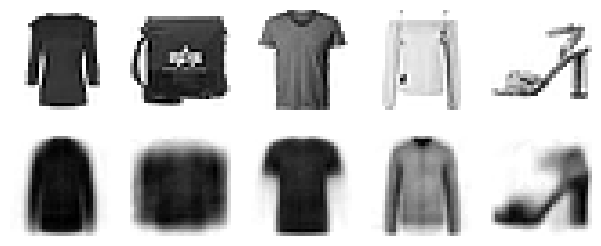

In [141]:
plot_reconstructions(hashing_ae)
plt.show()

In [142]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
  print(f"{h:016b}")
print("...")

157/157 [==============================] - 0s 1ms/step
1001101011111111
1011011001111111
1001011011111101
1000100101100111
1110011101000111
...


In [143]:
from collections import Counter

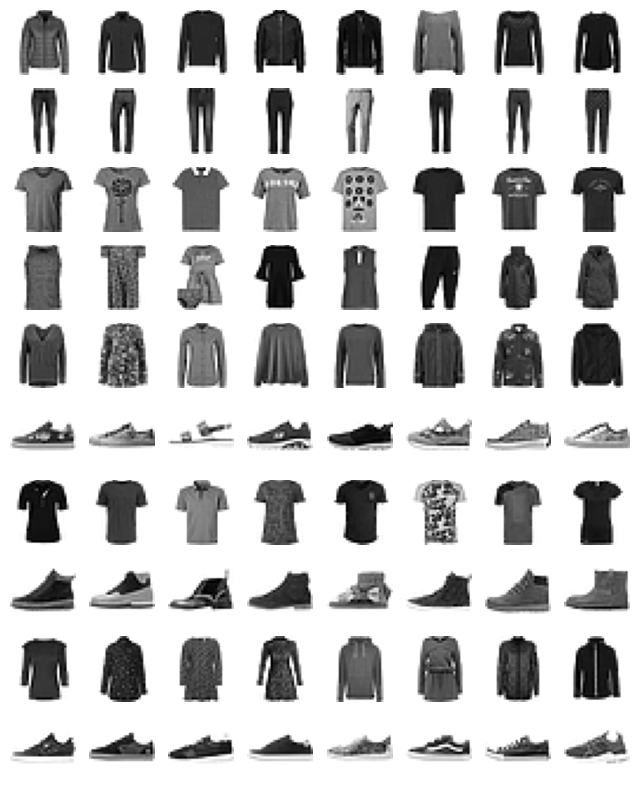

In [144]:
n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
  indices = (hashes == image_hash)
  for index, image in enumerate(X_valid[indices][:n_images]):
    plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plt.show()

## § 17.11.	Exercises

10) Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [3]:
import tensorflow as tf

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [5]:
tf.random.set_seed(42)

denoising_encoder = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
])

In [6]:
denoising_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
    tf.keras.layers.Reshape([16, 16, 32]),
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="same", activation="sigmoid")
])

In [7]:
denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy",
                     optimizer="nadam",
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train,
                           epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 20s 9ms/step - loss: 0.5831 - mse: 0.0143 - val_loss: 0.6045 - val_mse: 0.0202
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5667 - mse: 0.0075 - val_loss: 0.5759 - val_mse: 0.0100
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5636 - mse: 0.0063 - val_loss: 0.5728 - val_mse: 0.0089
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5623 - mse: 0.0058 - val_loss: 0.5695 - val_mse: 0.0080
Epoch 5/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.5615 - mse: 0.0056 - val_loss: 0.5654 - val_mse: 0.0066
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5610 - mse: 0.0054 - val_loss: 0.5652 - val_mse: 0.0066
Epoch 7/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.5606 - mse: 0.0053 - val_loss: 0.5642 - val_mse: 0.0061
Epoch 8/10
1563/1563 [==============================] -

In [11]:
import numpy as np
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 18ms/step


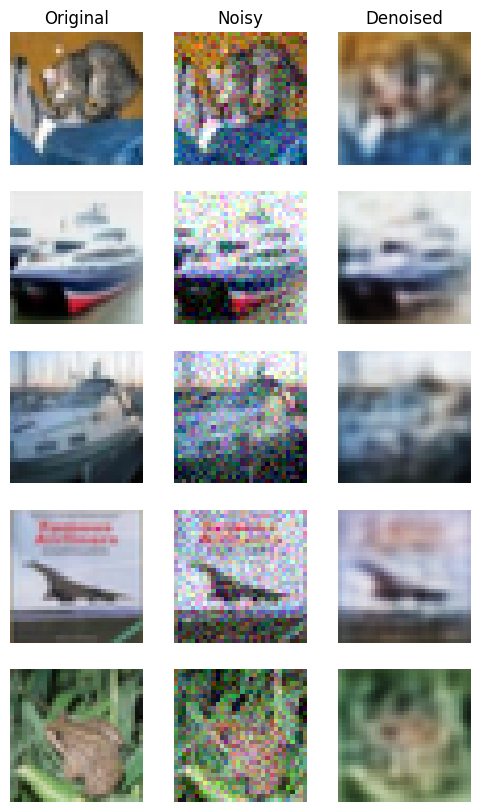

In [12]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
  plt.subplot(n_images, 3, index * 3 + 1)
  plt.imshow(new_images[index])
  plt.axis('off')
  if index == 0:
    plt.title("Original")
  plt.subplot(n_images, 3, index * 3 + 2)
  plt.imshow(new_images_noisy[index].clip(0., 1.))
  plt.axis('off')
  if index == 0:
    plt.title("Noisy")
  plt.subplot(n_images, 3, index * 3 + 3)
  plt.imshow(new_images_denoised[index])
  plt.axis('off')
  if index == 0:
    plt.title("Denoised")

plt.show()

11) Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples.

In [13]:
# see above

12) Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class.

In [14]:
# ditto